<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Basic Time Series Plotting</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

<div style="float:right; width:250 px"><img src="http://matplotlib.org/_images/date_demo.png" alt="METAR" style="height: 300px;"></div>


## Overview:

* **Teaching:** 45 minutes
* **Exercises:** 45 minutes

### Questions
1. How can we read data with Pandas?
1. How are plots created in Python?
1. What features does Matplotlib have for improving our time series plots?
1. How can we employ Python to make more complicated plots without complicated code?

### Objectives
1. <a href="#loaddata">Reading in data</a>
1. <a href="#basictimeseries">Basic timeseries plotting</a>
1. <a href="#multiy">Multiple y-axes</a>
1. <a href="#multipanel">Multi-panel plots</a>
    1. <a href="#iteration">Iteration and Enumeration</a>
    1. <a href="#functions">Functions</a>
    1. <a href="#plottingiteration">Plotting with Iteration</a>
    1. <a href="#multifile">Plotting Multiple Files</a>

<a name="loaddata"></a>
## Reading in Data
To learn about time series analysis, we first need to find some data and get it into Python. In this case we're going to use a file that was downloaded from the [National Data Buoy Center](http://www.ndbc.noaa.gov). Specially we're going to look at [buoy 41056](http://www.ndbc.noaa.gov/station_page.php?station=41056) as hurricane Irma passed over it.

We'll use the [pandas](http://pandas.pydata.org) library for our data reading and modification as it provides a convenient way to subset and manipulate data. The data does not come in an easily usable format from the NDBC, so it's a good chance to get our hands dirty with real world data manipulation and time series plotting.

First, let's start out by reading the text file into a pandas dataframe. If we look at the file we can see it's in a "fixed-width" format - i.e. each column has the same number of characters always.

```
#YY  MM DD hh mm WDIR WSPD GST  WVHT   DPD   APD MWD   PRES  ATMP  WTMP  DEWP  VIS PTDY  TIDE
#yr  mo dy hr mn degT m/s  m/s     m   sec   sec degT   hPa  degC  degC  degC  nmi  hPa    ft
2017 09 21 19 00 140  8.0 11.0   1.1     6    MM  93 1009.0  28.5    MM    MM   MM -1.0    MM
2017 09 21 18 00 140  8.0 10.0   1.1     6    MM  90 1009.5  28.6    MM    MM   MM -1.3    MM
2017 09 21 17 00 150  8.0 11.0   1.2     7    MM  90 1010.1  28.6    MM    MM   MM -0.4    MM
2017 09 21 16 00 130  8.0 11.0   1.1     6    MM  89 1010.0  28.5    MM    MM   MM -0.4    MM
2017 09 21 15 00 140  9.0 11.0   1.1     6    MM 109 1010.8  28.8    MM    MM   MM +1.0    MM
```

The data columns are year, month, day, hour, minute, wind direction, wind speed, wind gust, wave height, dominant wave period, domininant wave direction, pressure, air temperature, water temperature, dewpoint, visibility, pressure tendency, and tide. As you can see, this buoy does not have all of those sensors, so some columns are filled with `MM`, representing missing data.

In [1]:
fname = '41056.txt'

In [2]:
import pandas as pd
df = pd.read_fwf(fname)

In [3]:
df

,#YY,MM,DD,hh,mm,WDIR WSPD GST,WVHT,DPD,APD,MWD PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
0,#yr,mo,dy,hr,mn,degT m/s m/s,m,sec,sec,degT hPa,degC,degC,degC,nmi,hPa,ft
1,2017,10,04,19,00,100 5.0 6.0,1.0,12,MM,15 1011.1,28.4,MM,MM,MM,-1.5,MM
2,2017,10,04,18,00,100 5.0 6.0,1.0,9,MM,9 1011.4,28.5,MM,MM,MM,-1.5,MM
3,2017,10,04,17,00,110 5.0 7.0,0.9,9,MM,10 1011.9,28.4,MM,MM,MM,-1.2,MM
4,2017,10,04,16,00,100 5.0 6.0,0.8,9,MM,8 1012.6,28.3,MM,MM,MM,-0.3,MM
5,2017,10,04,15,00,110 5.0 6.0,0.9,8,MM,39 1012.9,28.3,MM,MM,MM,+0.8,MM
6,2017,10,04,14,00,110 5.0 6.0,0.8,9,MM,38 1013.1,28.3,MM,MM,MM,+1.5,MM
7,2017,10,04,13,00,110 4.0 5.0,1.6,9,MM,44 1012.9,28.3,MM,MM,MM,+1.7,MM
8,2017,10,04,12,00,100 5.0 6.0,0.8,9,MM,65 1012.1,28.2,MM,MM,MM,+1.1,MM
9,2017,10,04,11,00,110 5.0 6.0,0.8,9,MM,64 1011.6,28.1,MM,MM,MM,+0.7,MM


Getting the data read was pretty easy, but we immediatly see that we've got some cleanup to do. The header row contains column names that are less than ideal. The first data row is actually a row of units as well. We also notice that the date is broken up between multiple columns. It would be nice to have that as one timestamp that is a Python datetime object. Finally, we need to replace `MM` with `NaN`. Luckily these tasks are not too onerous with pandas.

In [4]:
# Much better column names, remember to be descriptive and use tab completion when using these!
col_names = ['year', 'month', 'day', 'hour', 'minute', 'wind_direction', 'wind_speed',
             'wind_gust', 'wave_height', 'dominant_wave_period', 'average_wave_period',
             'dominant_wave_direction', 'pressure', 'temperature', 'water_temperature', 'dewpoint',
             'visibility', '3hr_pressure_tendency', 'water_level_above_mean']

In [5]:
df = pd.read_fwf(fname, skiprows=2, na_values='MM', names=col_names)

While we're manupulating the data frame, let's get rid of the columns with all missing data. We could use the `drop` method and manually name all of the columns, but that would require us to know which are all `NaN` and that sounds like manual labor - something that programmers hate. Pandas has the `dropna` method that allows us to drop rows or columns where any or all values are `NaN`. In this case, let's drop all columns with all `NaN` values.

In [6]:
df = df.dropna(axis='columns', how='all')

In [7]:
df.head()

,year,month,day,hour,minute,wind_direction,wind_speed,wind_gust,wave_height,dominant_wave_period,dominant_wave_direction,pressure,temperature,3hr_pressure_tendency,water_level_above_mean
0,2017,10,4,19,0,100,5.0,6.0,1.0,12.0,15.0,1011.1,28.4,-1.5,NaN
1,2017,10,4,18,0,100,5.0,6.0,1.0,9.0,9.0,1011.4,28.5,-1.5,NaN
2,2017,10,4,17,0,110,5.0,7.0,0.9,9.0,10.0,1011.9,28.4,-1.2,NaN
3,2017,10,4,16,0,100,5.0,6.0,0.8,9.0,8.0,1012.6,28.3,-0.3,NaN
4,2017,10,4,15,0,110,5.0,6.0,0.9,8.0,39.0,1012.9,28.3,0.8,NaN


Next, let's get the time stamps fixed up nicely. We need to combine the columns `year` `month` `day` `hour` and `minute` into a single column called `time`. We could cast all of these columns as strings, build the date time stamp string, then parse that, but that's a lot of steps! Looking in the documentation, we see that `parse_dates` can do all that for us. Here's an example of combining the `year` and `month` columns.

In [8]:
df = pd.read_fwf(fname, skiprows=2, na_values='MM', names=col_names)
df['time'] = pd.to_datetime(df[['year', 'month', 'day']])

In [9]:
df.head()

,year,month,day,hour,minute,wind_direction,wind_speed,wind_gust,wave_height,dominant_wave_period,average_wave_period,dominant_wave_direction,pressure,temperature,water_temperature,dewpoint,visibility,3hr_pressure_tendency,water_level_above_mean,time
0,2017,10,4,19,0,100,5.0,6.0,1.0,12.0,NaN,15.0,1011.1,28.4,NaN,NaN,NaN,-1.5,NaN,2017-10-04
1,2017,10,4,18,0,100,5.0,6.0,1.0,9.0,NaN,9.0,1011.4,28.5,NaN,NaN,NaN,-1.5,NaN,2017-10-04
2,2017,10,4,17,0,110,5.0,7.0,0.9,9.0,NaN,10.0,1011.9,28.4,NaN,NaN,NaN,-1.2,NaN,2017-10-04
3,2017,10,4,16,0,100,5.0,6.0,0.8,9.0,NaN,8.0,1012.6,28.3,NaN,NaN,NaN,-0.3,NaN,2017-10-04
4,2017,10,4,15,0,110,5.0,6.0,0.9,8.0,NaN,39.0,1012.9,28.3,NaN,NaN,NaN,0.8,NaN,2017-10-04


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Read the data in again, but this time use all of the time stamp columns.</li>
      <li>Use the <code>drop</code> method to remove the now unused columns for year,
          month, day, hour, and minute. <b>HINT</b>: Look at the <code>axis</code> keyword
          argument in the documentation.</li>
    </ul>
</div>

In [10]:
# Your code goes here


In [11]:
# %load solutions/timeseries_parse_dates.py

<div class="alert alert-info">
    <b>TIP</b>:
    Many of the pandas functions have the <code>inplace</code> keyword argument. This allows us to modify the dataframe without continually needing to reassign it. <code>df = df.command(...)</code> becomes <code>df.command(..., inplace=True)</code>.
</div>

Finally, we need to trim down the data. The file contains 45 days worth of observations. We don't want to trim it too tightly and miss interesting things surroudning the hurricane's landfall, but having all 45 days is a bit overkill. Let's trim the data to dates between (and including) 9/18-9/23.

In [12]:
from datetime import datetime
idx = (df.time >= datetime(2017, 9, 18)) & (df.time <= datetime(2017, 9, 23))
df = df[idx]
df.head()

,year,month,day,hour,minute,wind_direction,wind_speed,wind_gust,wave_height,dominant_wave_period,average_wave_period,dominant_wave_direction,pressure,temperature,water_temperature,dewpoint,visibility,3hr_pressure_tendency,water_level_above_mean,time
259,2017,9,23,23,0,140,5.0,6.0,1.5,7.0,NaN,80.0,1012.9,28.3,NaN,NaN,NaN,1.0,NaN,2017-09-23
260,2017,9,23,22,0,140,6.0,7.0,0.8,6.0,NaN,73.0,1012.2,28.4,NaN,NaN,NaN,0.5,NaN,2017-09-23
261,2017,9,23,21,0,140,5.0,6.0,0.8,12.0,NaN,70.0,1012.0,28.4,NaN,NaN,NaN,-0.0,NaN,2017-09-23
262,2017,9,23,20,0,140,5.0,6.0,0.8,6.0,NaN,60.0,1011.9,28.4,NaN,NaN,NaN,-0.6,NaN,2017-09-23
263,2017,9,23,19,0,160,6.0,7.0,0.8,6.0,NaN,56.0,1011.7,28.6,NaN,NaN,NaN,-1.2,NaN,2017-09-23


We're almost ready, but now the index column is not that meaningful. It starts are row 306, which is fine with our initial file, but let's re-zero the index so we have a nice clean data frame to start with.

In [13]:
df.reset_index(drop=True, inplace=True)
df.head()

,year,month,day,hour,minute,wind_direction,wind_speed,wind_gust,wave_height,dominant_wave_period,average_wave_period,dominant_wave_direction,pressure,temperature,water_temperature,dewpoint,visibility,3hr_pressure_tendency,water_level_above_mean,time
0,2017,9,23,23,0,140,5.0,6.0,1.5,7.0,NaN,80.0,1012.9,28.3,NaN,NaN,NaN,1.0,NaN,2017-09-23
1,2017,9,23,22,0,140,6.0,7.0,0.8,6.0,NaN,73.0,1012.2,28.4,NaN,NaN,NaN,0.5,NaN,2017-09-23
2,2017,9,23,21,0,140,5.0,6.0,0.8,12.0,NaN,70.0,1012.0,28.4,NaN,NaN,NaN,-0.0,NaN,2017-09-23
3,2017,9,23,20,0,140,5.0,6.0,0.8,6.0,NaN,60.0,1011.9,28.4,NaN,NaN,NaN,-0.6,NaN,2017-09-23
4,2017,9,23,19,0,160,6.0,7.0,0.8,6.0,NaN,56.0,1011.7,28.6,NaN,NaN,NaN,-1.2,NaN,2017-09-23


<a href="#top">Top</a>
<hr style="height:2px;">

<a name="basictimeseries"></a>
## Basic Timeseries Plotting

Matplotlib is a python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms. We're going to learn the basics of creating timeseries plots with matplotlib by plotting buoy wind, gust, and pressure data.

In [14]:
# Convention for import of the pyplot interface
import matplotlib.pyplot as plt

# Set-up to have matplotlib use its support for notebook inline plots
%matplotlib inline

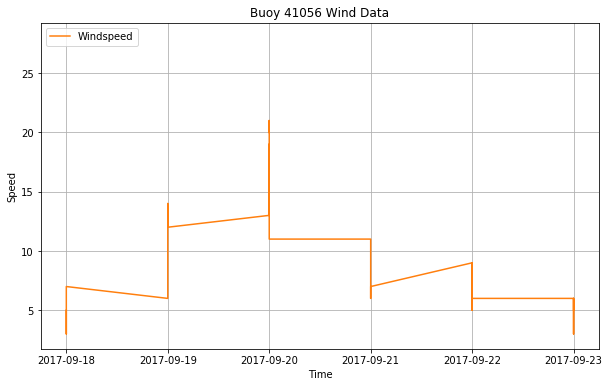

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(df.time, df.wind_speed, color='tab:orange', label='Windspeed')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Speed')
ax.set_title('Buoy 41056 Wind Data')
ax.grid(True)
ax.legend(loc='upper left')

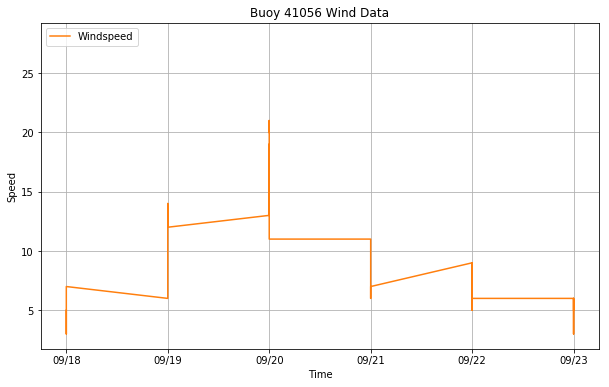

In [16]:
# Helpers to format and locate ticks for dates
from matplotlib.dates import DateFormatter, DayLocator

# Set the x-axis to do major ticks on the days and label them like '07/20'
ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))

fig

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
    <li>Add a yellow line with the gust speed. Set the <code>linestyle</code> keyword argument to <code>--</code>
        to produce a dashed line.</li>
    <li>Redisplay the legend on the plot to show your new wind gust line</li>
    <li>Change the x-axis major tick labels to read 'Sep DD' where DD is the day number. Look at the
        <a href="https://docs.python.org/3.6/library/datetime.html#strftime-and-strptime-behavior">
            table of formatters</a> for help.
    </ul>
</div>

<div class="alert alert-info">
    <b>Tip</b>:
     If your figure goes sideways as you try multiple things, try running the notebook up to this point again
     by using the Cell -> Run All Above option in the menu bar.
</div>

In [17]:
# Your code goes here


In [18]:
# %load solutions/timeseries_gustplot.py

<a href="#top">Top</a>
<hr style="height:2px;">

<a name="multiy"></a>
## Multiple y-axes
What if we wanted to plot another variable in vastly different units on our plot?

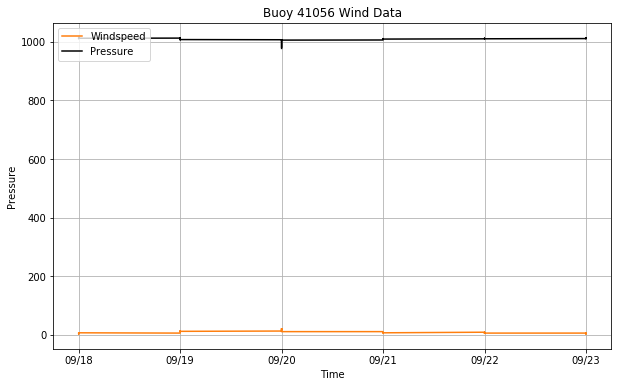

In [19]:
ax.plot(df.time, df.pressure, color='black', label='Pressure')
ax.set_ylabel('Pressure')

ax.legend(loc='upper left')

fig

That is less than idea. We can't see detail in the data profiles! We can create a twin of the x-axis and have a secondary y-axis on the right side of the plot. We'll create a totally new figure here.

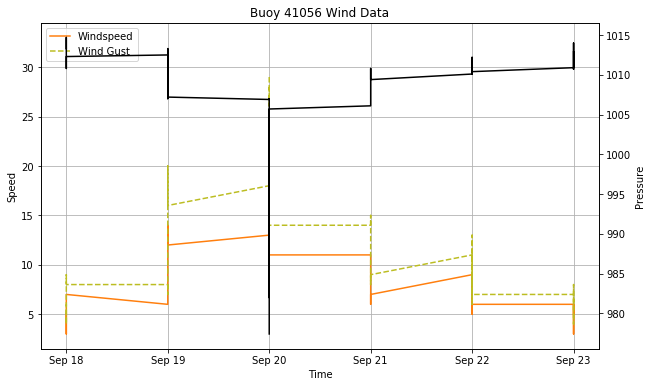

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
axb = ax.twinx()

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Speed')
ax.set_title('Buoy 41056 Wind Data')
ax.grid(True)
ax.legend(loc='upper left')

# Plotting on the first y-axis
ax.plot(df.time, df.wind_speed, color='tab:orange', label='Windspeed')
ax.plot(df.time, df.wind_gust, color='tab:olive', linestyle='--', label='Wind Gust')

# Plotting on the second y-axis
axb.set_ylabel('Pressure')
axb.plot(df.time, df.pressure, color='black', label='pressure')

ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))

ax.legend(loc='upper left')

We're closer, but the data are plotting over the legend and not included in the legend. That's because the legend is associated with our primary y-axis. We need to append that data from the second y-axis.

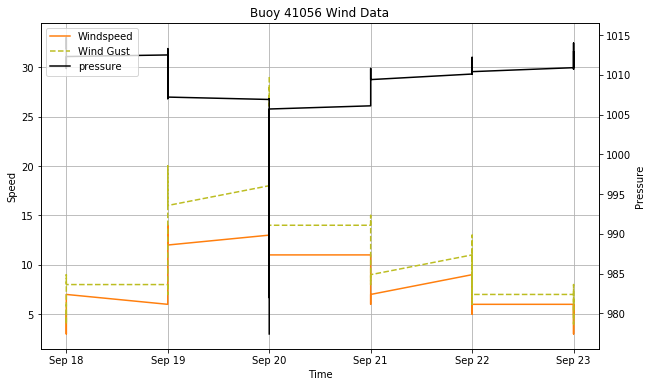

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
axb = ax.twinx()

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Speed')
ax.set_title('Buoy 41056 Wind Data')
ax.grid(True)
ax.legend(loc='upper left')

# Plotting on the first y-axis
ax.plot(df.time, df.wind_speed, color='tab:orange', label='Windspeed')
ax.plot(df.time, df.wind_gust, color='tab:olive', linestyle='--', label='Wind Gust')

# Plotting on the second y-axis
axb.set_ylabel('Pressure')
axb.plot(df.time, df.pressure, color='black', label='pressure')

ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b %d'))

# Handling of getting lines and labels from all axes for a single legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = axb.get_legend_handles_labels()
axb.legend(lines + lines2, labels + labels2, loc='upper left')

<a href="#top">Top</a>
<hr style="height:2px;">

<a name="multipanel"></a>
## Multi-panel Plots

Often we wish to create figures with multiple panels of data. It's common to separate variables of different types into these panels. We also don't want to create each panel as an individual figure and combine them in a tool like Illustrator - imagine having to do that for hundreds of plots!

We can use the `subplots` method to specify a number of rows and columns of plots in our figure:

Text(0.5,0.98,'Buoy 41056 Data')

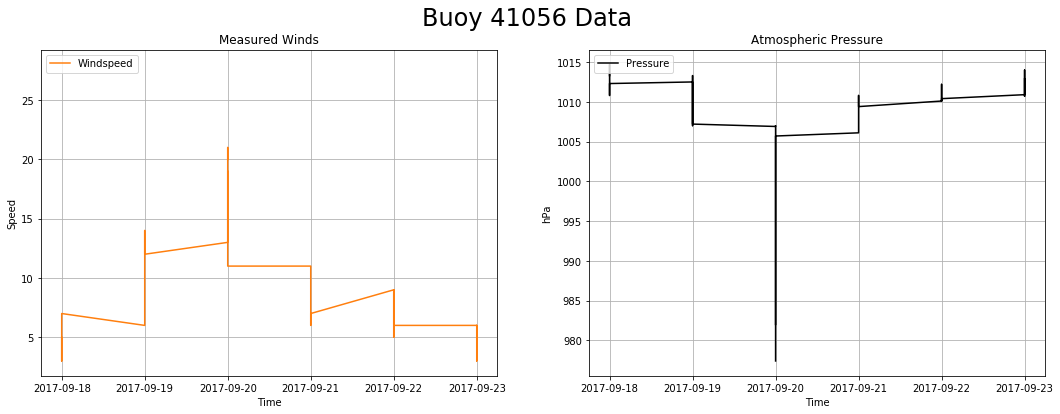

In [22]:
# ShareX means that the axes will share range, ticking, etc. for the x axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(18, 6))

# Panel 1
ax1.plot(df.time, df.wind_speed, color='tab:orange', label='Windspeed')
ax1.set_xlabel('Time')
ax1.set_ylabel('Speed')
ax1.set_title('Measured Winds')
ax1.legend(loc='upper left')
ax1.grid(True)

# Not repeated only by sharing x
ax1.xaxis.set_major_formatter(DateFormatter('%m/%d'))
ax1.xaxis.set_major_locator(DayLocator())

# Panel 2
ax2.plot(df.time, df.pressure, color='black', label='Pressure')
ax2.set_xlabel('Time')
ax2.set_ylabel('hPa')
ax2.set_title('Atmospheric Pressure')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.suptitle('Buoy 41056 Data', fontsize=24)

So even with the sharing of axis information, there's still a lot of repeated code. This current version with just two parameters might still be ok, but:

- What if we had more data being plotted on each axes?
- What if we had many subplots?
- What if we wanted to change one of the parameters?
- What if we wanted to plot data from different files on the same plot?

<a name="iteration"></a>
### Iteration and Enumeration
Iterating over lists is a very useful tool to reduce the amount of repeated code you write. We're going to start out by iterating over a single list with a `for` loop. Unlike C or other common scientific languages, Python 'knows' how to iterate over certain objects without you needing to specify an index variable and do the book keeping on that.

In [23]:
my_list = ['2001 A Space Obyssey',
           'The Princess Bride',
           'Monty Python and the Holy Grail']

for item in my_list:
    print(item)

2001 A Space Obyssey
The Princess Bride
Monty Python and the Holy Grail


Using the `zip` function we can even iterate over multiple lists at the same time with ease:

In [24]:
my_other_list = ['I\'m sorry, Dave. I\'m afraid I can\'t do that.',
                 'My name is Inigo Montoya.',
                 'It\'s only a flesh wound.']

for item in zip(my_list, my_other_list):
    print(item)

('2001 A Space Obyssey', "I'm sorry, Dave. I'm afraid I can't do that.")
('The Princess Bride', 'My name is Inigo Montoya.')
('Monty Python and the Holy Grail', "It's only a flesh wound.")


That's really handy, but needed to access each part of each item with an index like `item[0]` isn't very flexible, requires us to remember the layout of the item, and isn't best practice. Instead we can use Python's unpacking syntax to make things nice an intuitive.

In [25]:
for reference, quote in zip(my_list, my_other_list):
    print(reference, '-', quote)

2001 A Space Obyssey - I'm sorry, Dave. I'm afraid I can't do that.
The Princess Bride - My name is Inigo Montoya.
Monty Python and the Holy Grail - It's only a flesh wound.


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
    <li>Make two new lists named <code>plot_variables</code> and <code>plot_names</code>. Populate them
        with the variable name and plot label string for windspeed and pressure.</li>
    <li>Using the unpacking syntax, write a for loop that prints a sentence describing the action
        that would be taken (i.e. Plotting variable wind_speed as Windspeed</li>
    </ul>
</div>

In [26]:
# Your code goes here


In [27]:
# %load solutions/timeseries_parameter_iteration.py

We can use the `enumerate` function to 'count through' an iterable object as well. This can be useful when placing figures in certain rows/columns or when a counter is needed.

In [28]:
for i, quote in enumerate(my_other_list):
    print(i, ' - ', quote)

0  -  I'm sorry, Dave. I'm afraid I can't do that.
1  -  My name is Inigo Montoya.
2  -  It's only a flesh wound.


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
    <li>Combine what you've learned about enumeration and iteration to produce the following output:</li>
    </ul>
    <code>0  -  2001 A Space Obyssey  -  I'm sorry, Dave. I'm afraid I can't do that.
1  -  The Princess Bride  -  My name is Inigo Montoya.
2  -  Monty Python and the Holy Grail  -  It's only a flesh wound.</code>
</div>

In [29]:
# Your code goes here


In [30]:
# %load solutions/timeseries_enumeration.py

<a name="functions"></a>
### Functions
You're probably already familiar with Python functions, but here's a quick refresher. Functions are used to house blocks of code that we can run repeatedly. Paramters are given as inputs, and values are returned from the function to where it was called. In the world of programming you can think of functions like paragraphs, they encapsulate a complete idea/process.

Let's define a simple function that returns a value:

In [31]:
def silly_add(a, b):
    return a + b

We've re-implemented add which isn't incredibly exiciting, but that could be hundreds of lines of a numerical method, making a plot, or some other task. Using the function is simple:

In [32]:
result = silly_add(3, 4)
print(result)

7


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
    <li>Write a function that returns powers of 2. (i.e. calling <code>myfunc(4)</code> returns 2^4)</li>
    <li>**Bonus**: Using for loop iteration, print all powers of 2 from 0 to 24.</li>
    </ul>
</div>

In [33]:
# Your code goes here


In [34]:
# %load solutions/timeseries_functions.py

<a name="plottingiteration"></a>
### Plotting with Iteration
Now let's bring what we've learned about iteration to bear on the problem of plotting. We'll start with a basic example and roll into a more involved system at the end.

To begin, let's make an arbitrary number of plots in a single row:

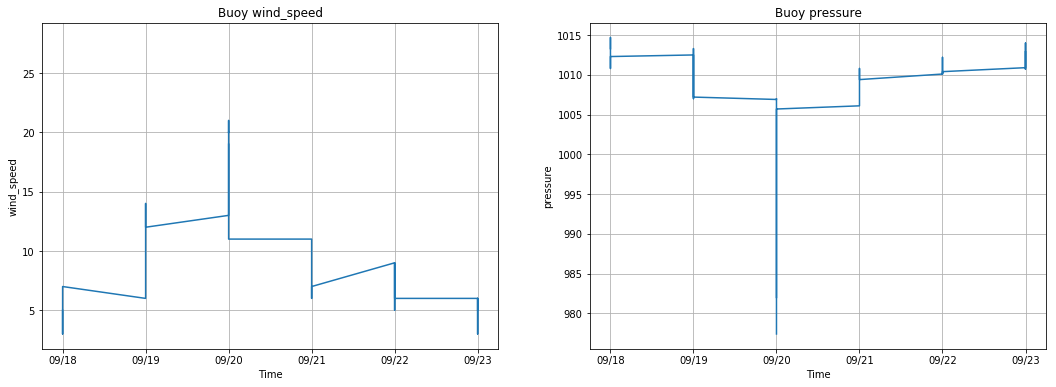

In [35]:
# A list of names of variables we want to plot
plot_variables = ['wind_speed', 'pressure']

# Make our figure, now choosing number of subplots based on length of variable name list
fig, axes = plt.subplots(1, len(plot_variables), sharex=True, figsize=(18, 6))

# Loop over the list of subplots and names together
for ax, var_name in zip(axes, plot_variables):
    
    ax.plot(df.time, df[var_name])

    # Set label/title based on variable name--no longer hard-coded
    ax.set_ylabel(var_name)
    ax.set_title('Buoy {}'.format(var_name))

    # Set up our formatting--note lack of repetition
    ax.grid(True)
    ax.set_xlabel('Time')
    ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(DayLocator())

It's a step forward, but we've lost a lot of formatting information. The lines are both blue, the labels as less ideal, and the title just uses the variable name. We can use some of Python's features like dictionaries, functions, and string manipulation to help improve the versatility of the plotter.

To start out, let's get the line color functionality back by using a Python dictionary to hold that information. Dictionaries can hold any data type and allow you to access that value with a key (hence the name key-value pair). We'll use the variable name for the key and the value will be the color of line to plot.

In [36]:
colors = {'wind_speed': 'tab:orange', 'wind_gust': 'tab:olive', 'pressure': 'black'}

To access the value, just access that element of the dictionary with the key.

In [37]:
colors['pressure']

'black'

Now let's apply that to our plot. We'll use the same code from the previous example, but now look up the line color in the dictionary.

NameError: name 'name' is not defined

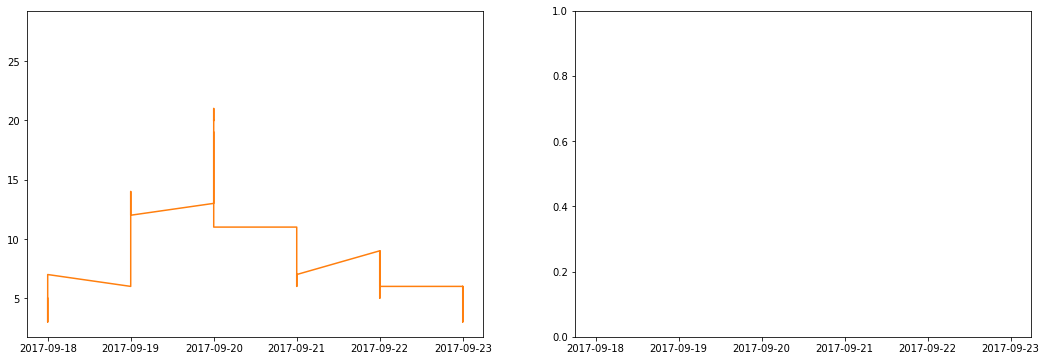

In [38]:
fig, axes = plt.subplots(1, len(plot_variables), sharex=True, figsize=(18, 6))

for ax, var_name in zip(axes, plot_variables):

    # Grab the color from our dictionary and pass it to plot()
    color = colors[var_name]
    ax.plot(df.time, df[var_name], color)

    ax.set_ylabel(name)
    ax.set_title('Buoy {}'.format(var_name))

    ax.grid(True)
    ax.set_xlabel('Time')
    ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(DayLocator())

That's already much better. We need to be able to plot multiple variables on the wind speed/gust plot though. In this case, we'll allow a list of variables for each plot to be given and iterate over them. We'll store this in a list of lists. Each plot has its own list of variables!

In [ ]:
plot_variables = [['wind_speed', 'wind_gust'], ['pressure']]

fig, axes = plt.subplots(1, len(plot_variables), sharex=True, figsize=(18, 6))

for ax, var_names in zip(axes, plot_variables):

    for var_name in var_names:
        # Grab the color from our dictionary and pass it to plot()
        color = colors[var_name]
        ax.plot(df.time, df[var_name], color)

    ax.set_ylabel(var_name)
    ax.set_title('Buoy {}'.format(var_name))

    ax.grid(True)
    ax.set_xlabel('Time')
    ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(DayLocator())

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
    <li>Create a dictionary of linestyles in which the variable name is the key and the linestyle is the value.</li>
    <li>Use that dictionary to modify the code below to plot the lines with the styles you specified.</li>
    </ul>
</div>

In [ ]:
# Create your linestyles dictionary and modify the code below

fig, axes = plt.subplots(1, len(plot_variables), sharex=True, figsize=(18, 6))

for ax, var_names in zip(axes, plot_variables):

    for var_name in var_names:
        # Grab the color from our dictionary and pass it to plot()
        color = colors[var_name]
        ax.plot(df.time, df[var_name], color)

    ax.set_ylabel(var_name)
    ax.set_title('Buoy {}'.format(var_name))

    ax.grid(True)
    ax.set_xlabel('Time')
    ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(DayLocator())

In [ ]:
# %load solutions/timeseries_linestyles.py

We're almost back to where to started, but in a much more versatile form! We just need to make the labels and titles look nice. To do that, let's write a function that uses some string manipulation to clean up the variable names and give us an axis/plot title and legend label.

In [ ]:
def format_varname(varname):
    parts = varname.split('_')
    title = parts[0].title()
    label = varname.replace('_', ' ').title()
    return title, label

In [ ]:
fig, axes = plt.subplots(1, len(plot_variables), sharex=True, figsize=(18, 6))

for ax, var_names in zip(axes, plot_variables):

    for var_name in var_names:
        
        title, label = format_varname(var_name)
        
        color = colors[var_name]
        linestyle = linestyles[var_name]
        ax.plot(df.time, df[var_name], color, linestyle=linestyle, label=label)

    ax.set_ylabel(title)
    ax.set_title('Buoy {}'.format(title))

    ax.grid(True)
    ax.set_xlabel('Time')
    ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(DayLocator())
    ax.legend(loc='upper left')

<a href="#top">Top</a>
<hr style="height:2px;">

<a name="multifile"></a>
## Plotting Multiple Files

Finally, let's plot data for two buoys on the same figure by iterating over a list of file names. We can use enumerate to plot each file on a new row of the figure.

In [ ]:
def read_buoy_data(fname):
    """Handy function to read and cleanup the buoy data files."""
    df = pd.read_fwf(fname, skiprows=2, na_values='MM', names=col_names)

    df['time'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])

    # Using inplace means the return is None and the dataframe is simply modified.
    df.drop(['year', 'month', 'day', 'hour', 'minute'], axis='columns', inplace=True)
    
    idx = (df.time >= datetime(2017, 9, 18)) & (df.time <= datetime(2017, 9, 23))
    df = df[idx]
    
    df.reset_index(drop=True, inplace=True)
    
    return df

In [ ]:
files = ['41056.txt', '41052.txt']

fig, axes = plt.subplots(len(files), len(plot_variables), sharex=True, figsize=(14, 10))

for row, filename in enumerate(files):
    df = read_buoy_data(filename)
    

    for col, var_names in enumerate(plot_variables):
        ax = axes[row,col]
        for var_name in var_names:
            title, label = format_varname(var_name)
            color = colors[var_name]
            linestyle = linestyles[var_name]
            ax.plot(df.time, df[var_name], color, linestyle=linestyle, label=label)

        ax.set_ylabel(title)
        ax.set_title('Buoy {} {}'.format(filename.split('.')[0], title))

        ax.grid(True)
        ax.set_xlabel('Time')
        ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))
        ax.xaxis.set_major_locator(DayLocator())

<a href="#top">Top</a>
<hr style="height:2px;">